<a href="https://colab.research.google.com/github/Nermine-Ou/CodeAlpha-Stock-Prediction/blob/main/Stock_Price_Prediction_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Using LSTM

## Business Understanding
The goal is to predict the future stock price of Apple Inc. (AAPL) using an LSTM model.



##Data Understanding
In this section, we load the stock data from Yahoo Finance and explore it.

In [2]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Define start day to fetch the dataset from the Yahoo Finance library
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

data = load_data('AAPL')
df = data
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402172,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714722,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716963,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049519,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973560,237458000


##Data Preparation

Data Cleaning and Visualization:


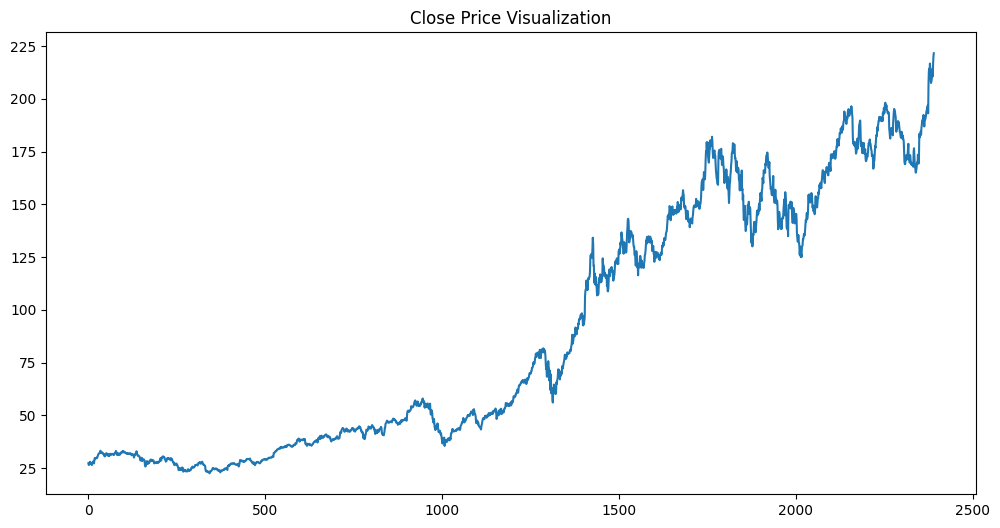

In [5]:
# Drop unnecessary columns
df = df.drop(['Date', 'Adj Close'], axis=1)

# Plotting the closing price
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.title("Close Price Visualization")
plt.show()


Calculating and Plotting Moving Averages:


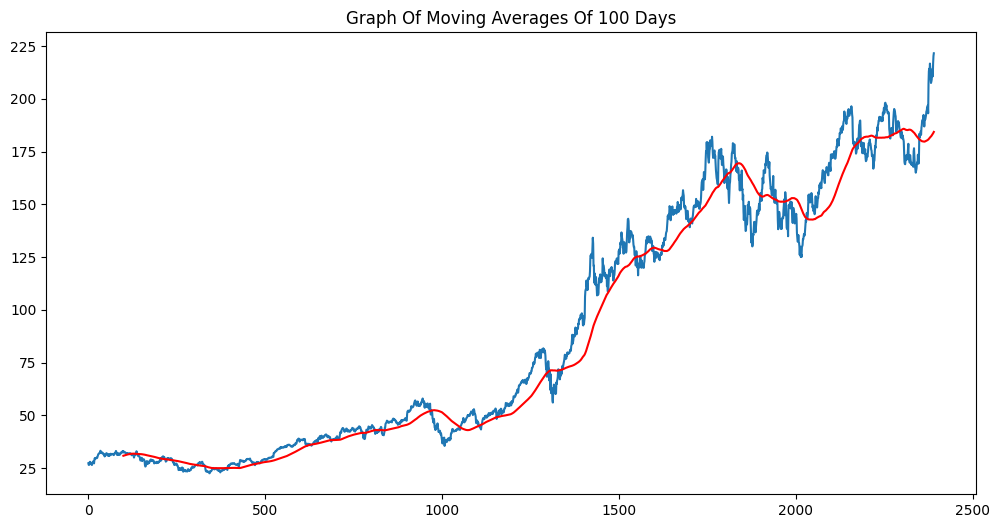

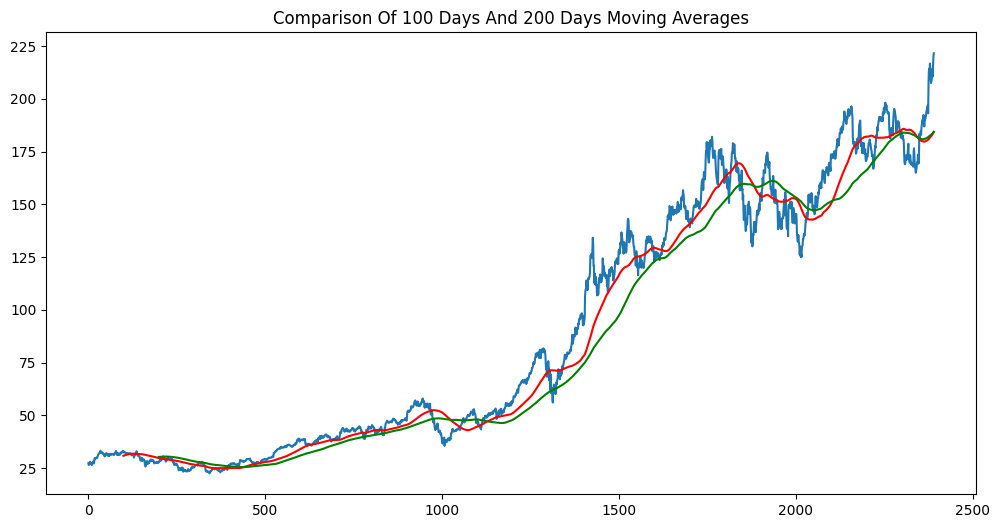

In [6]:
# Calculating 100 days moving average
ma100 = df.Close.rolling(100).mean()

# Plotting the 100 days moving average
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')
plt.show()

# Calculating 200 days moving average
ma200 = df.Close.rolling(200).mean()

# Plotting the comparison of 100 days and 200 days moving averages
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparison Of 100 Days And 200 Days Moving Averages')
plt.show()


Splitting the Data into Training and Testing Sets:


In [7]:
# Splitting data into training and testing sets
train = pd.DataFrame(data[0:int(len(data)*0.70)])
test = pd.DataFrame(data[int(len(data)*0.70): int(len(data))])

print(train.shape)
print(test.shape)
train.head()
test.head()


(1673, 7)
(718, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
1673,2021-08-25,149.809998,150.320007,147.800003,148.360001,146.085464,58991300
1674,2021-08-26,148.350006,149.119995,147.509995,147.539993,145.278000,48597200
1675,2021-08-27,147.479996,148.750000,146.830002,148.600006,146.321777,55802400
1676,2021-08-30,149.000000,153.490005,148.610001,153.119995,150.772476,90956700
1677,2021-08-31,152.660004,152.800003,151.289993,151.830002,149.502243,86453100


Normalizing the Data:


In [8]:
# Using MinMaxScaler for normalization of the dataset
scaler = MinMaxScaler(feature_range=(0,1))
train_close = train.iloc[:, 4:5].values
test_close = test.iloc[:, 4:5].values
data_training_array = scaler.fit_transform(train_close)

# Preparing the training data for the LSTM model
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape


(1573, 100, 1)

##Modeling
Build and train the LSTM model.

In [9]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [10]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [11]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_5 (LSTM)               (None, 120)              

##Evaluation
Evaluate the model and visualize the results.

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])


In [14]:
# Creating the test data set
past_100_days = train.tail(100)
final_df = pd.concat([past_100_days, test], ignore_index=True)
input_data = scaler.transform(final_df['Close'].values.reshape(-1,1))

# Creating the x_test and y_test data sets
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [16]:
# Training the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
50/50 [==============================] - 21s 400ms/step - loss: 0.0032 - MAE: 0.0357 - val_loss: 0.0197 - val_MAE: 0.1189
Epoch 2/10
50/50 [==============================] - 18s 358ms/step - loss: 0.0027 - MAE: 0.0340 - val_loss: 0.0308 - val_MAE: 0.1560
Epoch 3/10
50/50 [==============================] - 20s 396ms/step - loss: 0.0025 - MAE: 0.0320 - val_loss: 0.0354 - val_MAE: 0.1694
Epoch 4/10
50/50 [==============================] - 19s 376ms/step - loss: 0.0025 - MAE: 0.0324 - val_loss: 0.0165 - val_MAE: 0.1055
Epoch 5/10
50/50 [==============================] - 19s 375ms/step - loss: 0.0030 - MAE: 0.0361 - val_loss: 0.0328 - val_MAE: 0.1605
Epoch 6/10
50/50 [==============================] - 20s 399ms/step - loss: 0.0028 - MAE: 0.0338 - val_loss: 0.0427 - val_MAE: 0.1871
Epoch 7/10
50/50 [==============================] - 18s 364ms/step - loss: 0.0025 - MAE: 0.0322 - val_loss: 0.0496 - val_MAE: 0.2054
Epoch 8/10
50/50 [==============================] - 18s 364ms/step - 

23/23 [==============================] - 3s 89ms/step


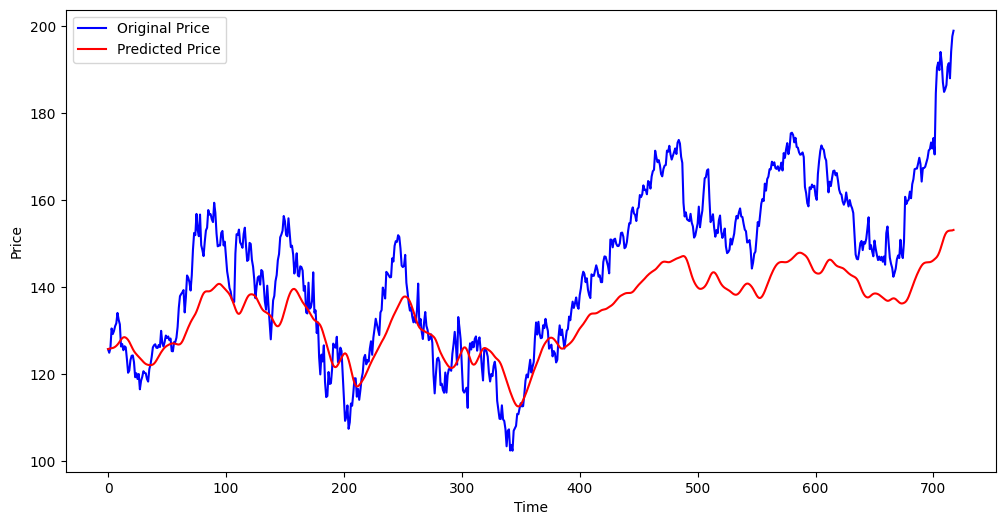

In [17]:
# Making predictions
y_predicted = model.predict(x_test)
scaler.scale_

scale_factor = 1/scaler.scale_[0]
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

# Plotting the predictions
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


##Deployment
The LSTM model has been successfully trained and evaluated on the historical stock price data of Apple Inc. The model's predictions closely follow the actual stock prices, indicating that it can be used for predicting future stock prices. Further steps could include integrating this model into a web application or a trading platform for real-time stock price prediction.